# Project Walkthrough

This notebook shows how to use the code present in this repository, including data extraction, preprocessing, and filtering. Let's begin!

### Data Mining

The first step needed is to gather and organize the data from the UDP packets outputed from the F1 CodeMasters racing game. To do so, you will need to provide the path to the motion directory of the UDP packet dataset. This will facilitate the extraction of the position, velocity, and heading vectors of all vehicles during the game.

In [1]:
path_to_motion_dir = r"C:\\Users\\chros\\Documents\\Deep Racing\\australia_run1\\udp_data\\motion_packets"  # Modify this line to wherever the motion directory is in your file system

We can now scrape the data from the UDP packets using the `scrape_udp_data(motion_directory, filename)` function in `data_scraper.py`. The filename parameter is the name of the file where the data will be stored in pickle format.

In [2]:
from data_scraper import scrape_udp_data

filename = "udp_data.pkl"
scrape_udp_data(path_to_motion_dir, filename=filename)

Pickle file already exists


### Data Preprocessing

Now that we have read the necessary data from the UDP packet dataset, we can filter the data to only show which cars are in the ego vehicle's field of view using `filter_data_in_view(filename, height, base)` in `preprocessing.py`. The field of view is represented using an outward facing isosceles triangle, where the `height` and `base` function parameters specify the height and base of the triangle.

In [3]:
from preprocessing import filter_data_in_view

height = 75 # in meters
base = 75 # in meters
filtered_data = filter_data_in_view(filename, height, base)

100%|██████████| 8724/8724 [00:02<00:00, 4108.17it/s]


We can visualize how the data is being filtered at specific timestamps using `visualize_ego_view(filename, height, base, timestamp)` in `visualize.py`.

Timestamp not found. Closest value to desired time was used:  150.017166
83.85254915624213
83.85254915624213


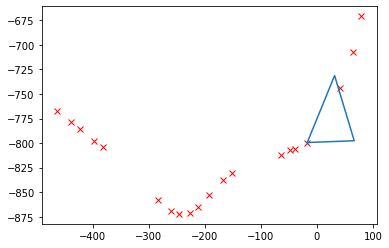

In [10]:
from visualize import visualize_ego_view

timestamp = 150  # session time in seconds (doesn't need to be exact)
visualize_ego_view(filename, height, base, timestamp)

The filter data is now stored in a 3-D numpy matrix, with the dimensions being `(timestamps, # of vehicles, vehicle data)`. The number of vehicles is always 20, since there are always 20 vehicles on the track during the race. The ID of a specific vehicle is constant throughout the race, meaning that the car present at index `i` of a specific timestamp is the same vehicle present at index `i` in every other timestamp. The dimensionality of the vehicle data is a single array with 12 values. This data is structured as follows.

| Index  &nbsp;&nbsp;&nbsp;&nbsp; |         Data        | 
| ------                          | :------------------ |
| 0                               | X-Position          |
| 1                               | Y-Position          |
| 2                               | Z-Position          |
| 3                               | X-Velocity          |
| 4                               | Y-Velocity          |
| 5                               | Z-Velocity          |
| 6                               | X-Forward Heading   |
| 7                               | Y-Forward Heading   |
| 8                               | Z-Forward Heading   |
| 9                               | X-Rightward Heading |
| 10                              | Y-Rightward Heading |
| 11                              | Z-Rightward Heading |

For each car in the filtered data, if the car is in the ego vehicle's field of view, then all of the data will be present. If the car is not currently in the ego's field of view, then that car's data vector will be zero padded. An example is shown in the cell below.

In [5]:
import pandas as pd
print(pd.DataFrame(filtered_data[100]))

            0         1           2          3         4          5        6   \
0  -116.433060  2.937785  461.677429 -21.627836 -0.178656 -20.704062 -23667.0   
1     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
2     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
3     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
4     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
5   -92.937508  3.124196  485.045288 -23.258335 -0.167096 -20.604710 -24540.0   
6  -104.800278  3.038994  473.685760 -23.338472 -0.139483 -20.644787 -24557.0   
7   -98.754929  3.049816  472.184052 -24.411583 -0.144423 -21.368427 -24694.0   
8     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
9     0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
10    0.000000  0.000000    0.000000   0.000000  0.000000   0.000000      0.0   
11    0.000000  0.000000    

As seen above, vehicle IDs 0, 5, 6, 7, and 15 are currently in the ego vehicle's field of view.

#### Note: Vehicle Number 19 is the ID of the ego vehicle, and its data is present at every timestamp.